In [1]:
import sys, os
print("Kernel Python:", sys.executable)

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math

from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import torch
print("PyTorch:", torch.__version__)

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
import pytorch_lightning as pl

from tqdm import tqdm
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print("Current location:", os.getcwd())

Kernel Python: /work3/s232958/envs/esm_gpu/bin/python
PyTorch: 2.5.1
Using device: cuda
Current location: /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/ona_drafts


In [29]:
def create_key_padding_mask(embeddings, padding_value=0, offset=10):
    return (embeddings < (padding_value + offset)).all(dim=-1)

def create_mean_of_non_masked(embeddings, padding_mask):
    # Use masked select and mean to compute the mean of non-masked elements
    # embeddings should be of shape (batch_size, seq_len, features)
    seq_embeddings = []
    for i in range(embeddings.shape[0]): # looping over all batch elements
        non_masked_embeddings = embeddings[i][~padding_mask[i]] # shape [num_real_tokens, features]
        if len(non_masked_embeddings) == 0:
            print("You are masking all positions when creating sequence representation")
            sys.exit(1)
        mean_embedding = non_masked_embeddings.mean(dim=0) # sequence is represented by the single vecotr [1152] [features]
        seq_embeddings.append(mean_embedding)
    return torch.stack(seq_embeddings)

class MiniCLIP_w_transformer_crossattn(pl.LightningModule):

    def __init__(self, padding_value = -5000, embed_dimension=1152, num_recycles=2):

        super().__init__()
        self.num_recycles = num_recycles # how many times you iteratively refine embeddings with self- and cross-attention (ALPHA-Fold-style recycling).
        self.padding_value = padding_value
        self.embed_dimension = embed_dimension

        self.logit_scale = nn.Parameter(torch.tensor(math.log(1/0.07)))  # ~CLIP init

        self.transformerencoder =  nn.TransformerEncoderLayer(
            d_model=self.embed_dimension,
            nhead=8,
            dropout=0.1,
            batch_first=True,
            dim_feedforward=self.embed_dimension
            )
 
        self.norm = nn.LayerNorm(self.embed_dimension)  # For residual additions

        self.cross_attn = nn.MultiheadAttention(
            embed_dim=self.embed_dimension,
            num_heads=8,
            dropout=0.1,
            batch_first=True
        )

        self.prot_embedder = nn.Sequential(
            nn.Linear(self.embed_dimension, 640),
            nn.ReLU(),
            nn.Linear(640, 320),
        )
        
    def forward(self, pep_input, prot_input, pep_int_mask=None, prot_int_mask=None, int_prob=None, mem_save=True): # , pep_tokens, prot_tokens

        pep_mask = create_key_padding_mask(embeddings=pep_input,padding_value=self.padding_value)
        prot_mask = create_key_padding_mask(embeddings=prot_input,padding_value=self.padding_value)
 
        # Initialize residual states
        # pep_emb = pep_input.clone()
        # prot_emb = prot_input.clone()

        pep_emb  = pep_input
        prot_emb = prot_input
 
        for _ in range(self.num_recycles):

            # Transformer encoding with residual
            pep_trans = self.transformerencoder(self.norm(pep_emb), src_key_padding_mask=pep_mask)
            prot_trans = self.transformerencoder(self.norm(prot_emb), src_key_padding_mask=prot_mask)

            # Cross-attention with residual
            pep_cross, _ = self.cross_attn(query=self.norm(pep_trans), key=self.norm(prot_trans), value=self.norm(prot_trans), key_padding_mask=prot_mask)
            prot_cross, _ = self.cross_attn(query=self.norm(prot_trans), key=self.norm(pep_trans), value=self.norm(pep_trans), key_padding_mask=pep_mask)
            
            # Additive update with residual connection
            pep_emb = pep_emb + pep_cross  
            prot_emb = prot_emb + prot_cross

        pep_seq_coding = create_mean_of_non_masked(pep_emb, pep_mask)
        prot_seq_coding = create_mean_of_non_masked(prot_emb, prot_mask)
        
        # Use self-attention outputs for embeddings
        pep_seq_coding = F.normalize(self.prot_embedder(pep_seq_coding))
        prot_seq_coding = F.normalize(self.prot_embedder(prot_seq_coding))
 
        if mem_save:
            torch.cuda.empty_cache()
        
        scale = torch.exp(self.logit_scale).clamp(max=100.0)
        logits = scale * (pep_seq_coding * prot_seq_coding).sum(dim=-1) # Dot-Product for comparison
        
        return logits
    

    def training_step(self, batch, device):
        # Passing the sequences to the models
 
        embedding_pep = batch[0]
        embedding_prot = batch[1]
 
        embedding_pep = embedding_pep.to(device)
        embedding_prot = embedding_prot.to(device)

        positive_logits = self(embedding_pep, embedding_prot)
        
        rows, cols = torch.triu_indices(embedding_prot.size(0), embedding_prot.size(0), offset=1)         
        
        negative_logits = self(embedding_pep[rows,:,:], embedding_prot[cols,:,:], int_prob=0.0)

        positive_loss = F.binary_cross_entropy_with_logits(positive_logits, torch.ones_like(positive_logits).to(device))
 
        # loss of predicting peptide using partner
        negative_loss =  F.binary_cross_entropy_with_logits(negative_logits, torch.zeros_like(negative_logits).to(device))
        
        loss = (positive_loss + negative_loss) / 2
 
        torch.cuda.empty_cache()
        return loss
    
    def validation_step(self, batch, device):
        # Predict on random batches of training batch size
        embedding_pep = batch[0]
        embedding_prot = batch[1]
        embedding_pep = embedding_pep.to(device)
        embedding_prot = embedding_prot.to(device)

        with torch.no_grad():

            positive_logits = self(
                    embedding_pep,
                    embedding_prot,
                    # interaction_pep,
                    # interaction_prot,
                    # int_prob = 0.0
                    )
            
            # loss of predicting partner using peptide
            positive_loss = F.binary_cross_entropy_with_logits(positive_logits, torch.ones_like(positive_logits).to(device))
            
            # Negaive indexes
            rows, cols = torch.triu_indices(embedding_prot.size(0), embedding_prot.size(0), offset=1) 
            

            negative_logits = self(embedding_pep[rows,:,:], 
                              embedding_prot[cols,:,:], 
                              int_prob=0.0)
                   
            
            negative_loss =  F.binary_cross_entropy_with_logits(negative_logits, torch.zeros_like(negative_logits).to(device))

            loss = (positive_loss + negative_loss) / 2
           
            logit_matrix = torch.zeros((embedding_pep.size(0),embedding_pep.size(0)),device=self.device)
            logit_matrix[rows, cols] = negative_logits
            logit_matrix[cols, rows] = negative_logits
            
            # Fill diagonal with positive scores
            diag_indices = torch.arange(embedding_pep.size(0), device=self.device)
            logit_matrix[diag_indices, diag_indices] = positive_logits.squeeze()

            labels = torch.arange(embedding_prot.size(0)).to(self.device)
            peptide_predictions = logit_matrix.argmax(dim=0)
            peptide_ranks = logit_matrix.argsort(dim=0).diag() + 1
            peptide_mrr = (peptide_ranks).float().pow(-1).mean()
            
            # partner_accuracy = partner_predictions.eq(labels).float().mean()
            peptide_accuracy = peptide_predictions.eq(labels).float().mean()
    
            k = 3
            peptide_topk_accuracy = torch.any((logit_matrix.topk(k, dim=0).indices - labels.reshape(1, -1)) == 0, dim=0).sum() / logit_matrix.shape[0]
            # partner_topk_accuracy = torch.any((logits.topk(k, dim=1).indices - labels.reshape(-1, 1)) == 0, dim=1).sum() / logits.shape[0]
    
            del logit_matrix,positive_logits,negative_logits,embedding_pep,embedding_prot

            return loss, peptide_accuracy, peptide_topk_accuracy

    def calculate_logit_matrix(self,embedding_pep,embedding_prot):
        positive_logits = self(
            embedding_pep,
            embedding_prot)
        
        # Negaive indexes
        rows, cols = torch.triu_indices(embedding_pep.size(0), embedding_pep.size(0), offset=1) 
        
        negative_logits = self(embedding_pep[rows,:,:], 
                      embedding_prot[cols,:,:], 
                      int_prob=0.0)
        
        logit_matrix = torch.zeros((embedding_pep.size(0),embedding_pep.size(0)),device=self.device)
        logit_matrix[rows, cols] = negative_logits
        logit_matrix[cols, rows] = negative_logits
        # Fill diagonal with positive scores
        diag_indices = torch.arange(embedding_pep.size(0), device=self.device)
        logit_matrix[diag_indices, diag_indices] = positive_logits.squeeze()
        return logit_matrix

In [30]:
interaction_df = pd.read_csv("/work3/s232958/data/meta_analysis/interaction_df_metaanal.csv")[["A_seq", "B_seq", "target_id_mod", "target_binder_ID", "binder"]].rename(columns = {
    "A_seq" : "seq_binder",
    "B_seq" : "seq_target",
    "target_binder_ID" : "binder_id",
    "target_id_mod" : "target_id",
    "binder" : "binder_label"
})
interaction_df

# Targets df
target_df = interaction_df[["target_id","seq_target"]].rename(columns={"seq_target":"sequence", "target_id" : "ID"})
target_df["seq_len"] = target_df["sequence"].apply(len)
target_df = target_df.drop_duplicates(subset=["ID","sequence"])
target_df = target_df.set_index("ID")

# Binders df
binder_df = interaction_df[["binder_id","seq_binder"]].rename(columns={"seq_binder":"sequence", "binder_id" : "ID"})
binder_df["seq_len"] = binder_df["sequence"].apply(len)
binder_df = binder_df.set_index("ID")

# target_df

# Interaction Dict
interaction_Dict = dict(enumerate(zip(interaction_df["target_id"], interaction_df["binder_id"]), start=1))
# interaction_Dict

In [40]:
class CLIP_meta_analysis_dataset(Dataset):
    def __init__(self, sequence_df, esm_encoding_paths, embedding_dim=1280, padding_value=-5000, embedtype = "binders"):
        super(CLIP_meta_analysis_dataset, self).__init__()

        self.sigma = 1
        self.sequence_df = sequence_df
        self.max_length = sequence_df["seq_len"].max()
        self.sequence_df["index_num"] = np.arange(len(self.sequence_df))
        self.esm_encoding_paths = esm_encoding_paths
        num_samples = len(self.sequence_df)
        self.x = torch.full((num_samples, self.max_length, embedding_dim), padding_value, dtype=torch.float32)
        
        # Load embeddings into the pre-allocated tensor
        iterator = tqdm(self.sequence_df.index.tolist(), position=0, leave=True, total=num_samples, desc="# Reading in ESM-embeddings from folder")
        for i, accession in enumerate(iterator):
            try:
                embd = np.load(os.path.join(esm_encoding_paths, accession + ".npy"))[0]
                length_to_pad = self.max_length - len(embd)
                if length_to_pad > 0:
                    zero_padding = np.ones((length_to_pad, embd.shape[1])) * padding_value
                    padded_array = np.concatenate((embd, zero_padding), axis=0)
                else:
                    padded_array = embd[:self.max_length] 
                self.x[i] = torch.tensor(padded_array, dtype=torch.float32)
            except FileNotFoundError as e:
                raise FileNotFoundError(f"Embedding file {accession}.npy not found.")
                
    def __len__(self):
        return int(self.x.shape[0])

    def __getitem__(self, index):
        index1 = self.sequence_df.loc[index,"index_num"]
        return self.x[index1]

In [41]:
# targets_dataset = CLIP_meta_analysis_dataset(target_df, esm_encoding_paths="/work3/s232958/data/meta_analysis/targets_embeddings_esm2", embedding_dim=1280, embedtype = "targets")
# binders_dataset = CLIP_meta_analysis_dataset(binder_df, esm_encoding_paths="/work3/s232958/data/meta_analysis/binders_embeddings_esm2", embedding_dim=1280, embedtype = "binders")

targets_dataset = CLIP_meta_analysis_dataset(target_df, esm_encoding_paths="/work3/s232958/data/meta_analysis/targets_embeddings_esmC", embedding_dim=1152, embedtype = "targets")
binders_dataset = CLIP_meta_analysis_dataset(binder_df, esm_encoding_paths="/work3/s232958/data/meta_analysis/binders_embeddings_esmC", embedding_dim=1152, embedtype = "binders")

# Reading in ESM-embeddings from folder: 100%|█████████████████████████████████████████████████████████| 3532/3532 [00:08<00:00, 409.23it/s]


In [42]:
binders_dataset["IL7Ra_4"].shape

torch.Size([250, 1152])

In [43]:
interaction_lst = list(interaction_Dict.values())
interaction_lst[:10]

[('VirB8', 'VirB8_1'),
 ('FGFR2', 'FGFR2_1'),
 ('FGFR2', 'FGFR2_2'),
 ('FGFR2', 'FGFR2_3'),
 ('FGFR2', 'FGFR2_4'),
 ('FGFR2', 'FGFR2_5'),
 ('FGFR2', 'FGFR2_6'),
 ('FGFR2', 'FGFR2_7'),
 ('FGFR2', 'FGFR2_8'),
 ('FGFR2', 'FGFR2_9')]

In [44]:
# Batching function:
def batch_list(iterable, batch_size=1):
    length = len(iterable)
    for start in range(0, length, batch_size):
        end = min(start + batch_size, length)
        yield iterable[start:end]

batch_size = 10
batched_tb = batch_list(interaction_lst, batch_size)

# num_batches = (len(interaction_lst) + batch_size - 1) // batch_size
# print(num_batches)

binders = [i[1] for i in interaction_lst[:20]]
binders_embd = [binders_dataset[i] for i in binders]
binders_embd[0].shape

torch.Size([250, 1152])

In [45]:
# path = 'trained/PPint_retrain10%_0.4_Christian/e6274a80-1376-44cc-9131-66e907202845_checkpoint_3/e6274a80-1376-44cc-9131-66e907202845_checkpoint_epoch_3.pth'
# path = 'trained/PPint_retrain10%_0.4_Christian/251115/604de5a9-0626-43e4-b371-d001b8a528d0_checkpoint_11/604de5a9-0626-43e4-b371-d001b8a528d0_checkpoint_epoch_11.pth'
# path = '/work3/s232958/data/trained/PPint_retrain10%_0.4_Christian/251116_49df0f83-0ec8-4155-80f0-07b4696f06bf/49df0f83-0ec8-4155-80f0-07b4696f06bf_checkpoint_12/49df0f83-0ec8-4155-80f0-07b4696f06bf_checkpoint_epoch_12.pth'
path = '/work3/s232958/data/trained/PPint_retrain10%_0.4_Christian/251116_0e035ba9-3cbd-4aab-be0b-cc2e37723b27/0e035ba9-3cbd-4aab-be0b-cc2e37723b27_checkpoint_2/0e035ba9-3cbd-4aab-be0b-cc2e37723b27_checkpoint_epoch_2.pth'
# path = 'trained/PPint_retrain10%_0.4_Christian/251115/604de5a9-0626-43e4-b371-d001b8a528d0_checkpoint_8/604de5a9-0626-43e4-b371-d001b8a528d0_checkpoint_epoch_8.pth'
checkpoint = torch.load(path, weights_only=False, map_location=torch.device('cpu'))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = MiniCLIP_w_transformer_crossattn()
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

MiniCLIP_w_transformer_crossattn(
  (transformerencoder): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=1152, out_features=1152, bias=True)
    )
    (linear1): Linear(in_features=1152, out_features=1152, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=1152, out_features=1152, bias=True)
    (norm1): LayerNorm((1152,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((1152,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (norm): LayerNorm((1152,), eps=1e-05, elementwise_affine=True)
  (cross_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=1152, out_features=1152, bias=True)
  )
  (prot_embedder): Sequential(
    (0): Linear(in_features=1152, out_features=640, bias=True)
    (1): ReLU()
    (2): Linear(in_features=640, out_features=32

In [46]:
# Loading batches
interaction_scores = []

for batch in tqdm(batched_tb, total = round(len(interaction_df)/batch_size),  desc= "#Iterating through batched data"):
    targets_acc = [taget_binder[0] for taget_binder in batch]
    targets_embd = [targets_dataset[i] for i in targets_acc]
    binders_acc = [taget_binder[1] for taget_binder in batch]
    binders_embd = [binders_dataset[i] for i in binders_acc]

    # binders_dataloader = DataLoader(binders_embd, batch_size=batch_size, shuffle=False)
    # targets_dataloader = DataLoader(targets_embd, batch_size=batch_size, shuffle=False)

    binders_batch = torch.stack([binders_dataset[i] for i in binders_acc]).to(device)
    targets_batch = torch.stack([targets_dataset[i] for i in targets_acc]).to(device)
    # binders_batch = next(iter(binders_dataloader)).to(device)
    # targets_batch = next(iter(targets_dataloader)).to(device)
    
    with torch.no_grad():
        logits = model(binders_batch, targets_batch)
        # CLIP_logits represents probailbities of interacting CLIP_logits[i] = prob of mb_batch[i] interacting with hp_index
        interaction_scores.append(logits.unsqueeze(0))
        # print(interaction_scores)

#Iterating through batched data: 354it [00:25, 14.08it/s]                                                                                   


In [47]:
predicted_interaction_scores = np.concatenate([batch_score.cpu().detach().numpy().reshape(-1,) for batch_score in interaction_scores])
interaction_probabilities = np.concatenate([torch.sigmoid(batch_score[0]).cpu().numpy() for batch_score in interaction_scores])

interaction_df["inter_prob"] = interaction_probabilities
interaction_df["binder_label_pred"] = interaction_df["inter_prob"] >= 0.5
interaction_df["intr_scores"] = predicted_interaction_scores

interaction_df

,seq_binder,seq_target,target_id,binder_id,binder_label,inter_prob,binder_label_pred,intr_scores
0,LDFIVFAGPEKAIKFYKEMAKRNLEVKIWIDGDWAVVQVK,ANPYISVANIMLQNYVKQREKYNYDTLKEQFTFIKNASTSIVYMQF...,VirB8,VirB8_1,False,0.091297,False,-2.297896
1,SEQDETMHRIVRSVIQHAYKHNDEMAEYFAQNAAEIYKEQNKSEEA...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_1,False,0.068515,False,-2.609730
2,DYKQLKKHATKLLELAKKDPSSKRDLLRTAASYANKVLFEDSDPRA...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_2,False,0.043665,False,-3.086567
3,DEKEELERRANRVAFLAIQIQNEEYHRILAELYVQFMKAAENNDTE...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_3,False,0.037765,False,-3.237874
4,PDNKEKLMSIAVQLILRINEAARSEEQWRYANRAAFAAVEASSGSD...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_4,False,0.068213,False,-2.614462
...,...,...,...,...,...,...,...,...
3527,DLRKYAAELVDRLAEKYNLDSDQYNALVRLASELVWQGKSKEEIEK...,ELCDDDPPEIPHATFKAMAYKEGTMLNCECKRGFRRIKSGSLYMLC...,IL2Ra,IL2Ra_62,False,0.065263,False,-2.661835
3528,SKEEIKKEAEELIEELKKKGYNLPLRILEFALKEIEETNSEKYYEQ...,ELCDDDPPEIPHATFKAMAYKEGTMLNCECKRGFRRIKSGSLYMLC...,IL2Ra,IL2Ra_63,False,0.022691,False,-3.762822
3529,SPEYKKFLELIKEAEAARKAGDLDKAKELLEKALELAKKMKAKSLI...,ELCDDDPPEIPHATFKAMAYKEGTMLNCECKRGFRRIKSGSLYMLC...,IL2Ra,IL2Ra_64,False,0.417020,False,-0.335018
3530,DPLLAYKLLKLSQKALEKAYAEDRERAEELLEEAEAALRSLGDEAG...,ELCDDDPPEIPHATFKAMAYKEGTMLNCECKRGFRRIKSGSLYMLC...,IL2Ra,IL2Ra_65,False,0.026340,False,-3.609974


In [48]:
labels = torch.as_tensor(interaction_df["binder_label_pred"].to_numpy(copy=False), dtype=torch.float32, device=device)
logits = torch.as_tensor(predicted_interaction_scores, dtype=torch.float32, device=device)

loss = F.binary_cross_entropy_with_logits(logits, labels)
loss

tensor(0.1142, device='cuda:0')

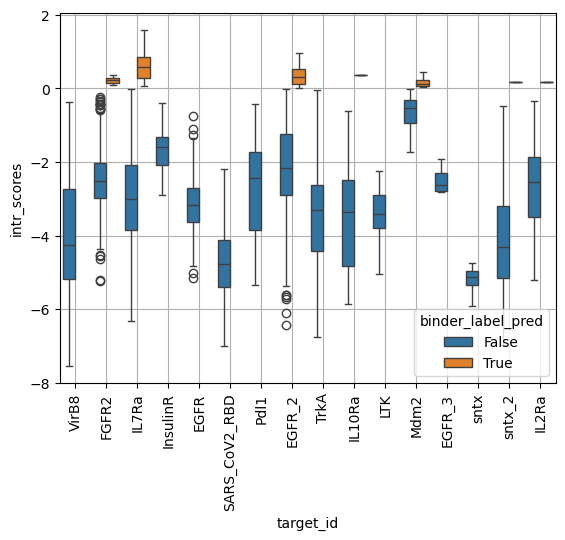

In [49]:
sns.boxplot(data=interaction_df,x="target_id",y="intr_scores",hue="binder_label_pred",legend=True)
plt.xticks(rotation=90)
plt.grid()
plt.show()

#%%
# import seaborn as sns
# sns.boxplot(data=interaction_df,x="target_id",y="af2_pae_interaction",hue="binder",legend=True)
# plt.xticks(rotation=90)
# plt.grid()
# plt.show()


# import seaborn as sns
# sns.boxplot(data=interaction_df,x="target_id",y="boltz_ipae",hue="binder",legend=True)
# plt.xticks(rotation=90)
# plt.grid()
# plt.show()

In [50]:
import sklearn

pred_labels = interaction_probabilities >= 0.5
true_labels = np.array(interaction_df["binder_label"])

true_positives = ((pred_labels == 1) & (true_labels == 1)).sum().item()
true_negatives = ((pred_labels == 0) & (true_labels == 0)).sum().item()
false_positives = ((pred_labels == 1) & (true_labels == 0)).sum().item()
false_negatives = ((pred_labels == 0) & (true_labels == 1)).sum().item()

predicted_positives = true_positives + false_positives
all_real_positives = true_positives + false_negatives

print(sklearn.metrics.classification_report(true_labels, pred_labels, digits = 4))

              precision    recall  f1-score   support

       False     0.8899    0.9882    0.9365      3141
        True     0.1591    0.0179    0.0322       391

    accuracy                         0.8808      3532
   macro avg     0.5245    0.5031    0.4843      3532
weighted avg     0.8090    0.8808    0.8364      3532



AUC: 0.523


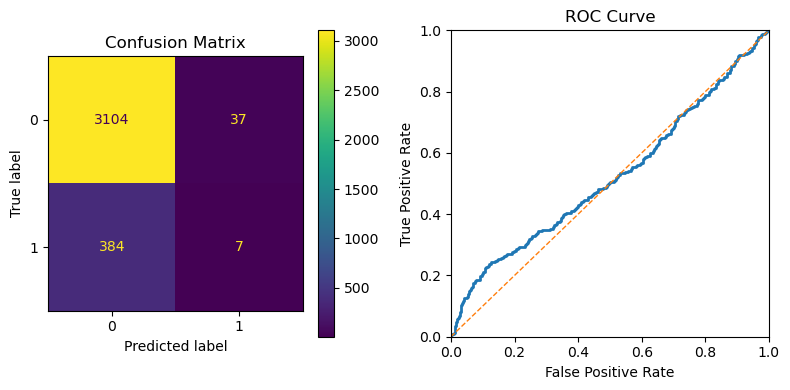

In [51]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(true_labels, pred_labels))
disp.plot(ax=axes[0])
axes[0].set_title("Confusion Matrix")

TPR = true_positives / (true_positives + true_negatives) # how good the model is at predicting the positive class when the actual outcome is positive.
# sensitivity = true_positives / (true_positives + false_negatives) # the same as TPR
FPR = false_positives / (false_positives + true_negatives) # how often a positive class is predicted when the actual outcome is negative.
# specificity = true_negatives / (true_negatives + false_positives) # FPR = 1 - specificity

fpr, tpr, thresholds = sklearn.metrics.roc_curve(true_labels, interaction_probabilities)
auc = roc_auc_score(true_labels, interaction_probabilities)
print('AUC: %.3f' % auc)

axes[1].plot(fpr, tpr, linewidth=2)
axes[1].plot([0, 1], [0, 1], linestyle="--", linewidth=1)  # diagonal reference
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_xlim(0, 1)
axes[1].set_ylim(0, 1)
axes[1].set_title('ROC Curve')

# show the plot
plt.tight_layout()
plt.show()

### Boltz, Colab and AlphaFold predictions

#### AUC-ROC

In [52]:
all_meta_dataframe = pd.read_csv("/zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/data_ona/final_dataset.csv")
all_meta_dataframe = all_meta_dataframe[(all_meta_dataframe["A_seq"].notna())& (all_meta_dataframe["B_seq"].notna())].reset_index(drop=True)
all_meta_dataframe = all_meta_dataframe[all_meta_dataframe["target_chains"] == "[\"B\"]"]
all_meta_dataframe = all_meta_dataframe[all_meta_dataframe["B_seq"].notna()].reset_index(drop=True)

In [53]:
dfu = all_meta_dataframe.drop_duplicates(["target_id", "B_seq"])
dfu[dfu.target_id == "EGFR"].B_seq.tolist()
targets_Dict, target_tracking = {}, {target:int(2) for target in dfu.target_id.unique()}

for idx, target_id in enumerate(dfu.target_id):
    if target_id not in targets_Dict.keys():
        targets_Dict[target_id] = dfu.iloc[idx]["B_seq"]
        # print(target_id)
    else:
        target_id_new = f"{target_id}_{target_tracking[target_id]}"
        targets_Dict[target_id_new] = dfu.iloc[idx]["B_seq"]
        count = target_tracking[target_id]
        target_tracking[target_id] = count + 1
        # print(target_id_new)

In [54]:
all_meta_dataframe['target_id_mod'] = all_meta_dataframe['B_seq'].map({b:a for a, b in targets_Dict.items()})
all_meta_dataframe['B_seq'].map({b:a for a, b in targets_Dict.items()})
print(targets_Dict.keys())
print(f"Entries wheere 'target_id_mod' is NA: {len(all_meta_dataframe[all_meta_dataframe.target_id_mod.isna() == True])}")

dict_keys(['VirB8', 'FGFR2', 'IL7Ra', 'InsulinR', 'EGFR', 'SARS_CoV2_RBD', 'Pdl1', 'EGFR_2', 'TrkA', 'IL10Ra', 'LTK', 'Mdm2', 'EGFR_3', 'sntx', 'sntx_2', 'IL2Ra'])
Entries wheere 'target_id_mod' is NA: 0


In [55]:
all_meta_dataframe.target_id_mod.unique()

array(['VirB8', 'FGFR2', 'IL7Ra', 'InsulinR', 'EGFR', 'SARS_CoV2_RBD',
       'Pdl1', 'EGFR_2', 'TrkA', 'IL10Ra', 'LTK', 'Mdm2', 'EGFR_3',
       'sntx', 'sntx_2', 'IL2Ra'], dtype=object)

In [56]:
cnt = interaction_df.groupby('target_id').cumcount() + 1
interaction_df['target_binder_ID'] = interaction_df['target_id'].astype(str) + '_' + cnt.astype(str)

cols = ["target_id_mod","all_meta_dataframe", "colab_iptm_model_0", "boltz1_iptm_model_0", "boltz1_complex_plddt_model_0", "af3_iptm_model_0"]
cols_to_add = all_meta_dataframe.filter(items=cols).copy()
cols_to_add['target_binder_ID'] = cols_to_add['target_id_mod'].astype(str) + '_' + cnt.astype(str)
cols_to_add = cols_to_add.drop(columns=["target_id_mod"])
combined_df = interaction_df.merge(cols_to_add, on="target_binder_ID", how="inner")
combined_df

,seq_binder,seq_target,target_id,binder_id,binder_label,inter_prob,binder_label_pred,intr_scores,target_binder_ID,colab_iptm_model_0,boltz1_iptm_model_0,boltz1_complex_plddt_model_0,af3_iptm_model_0
0,LDFIVFAGPEKAIKFYKEMAKRNLEVKIWIDGDWAVVQVK,ANPYISVANIMLQNYVKQREKYNYDTLKEQFTFIKNASTSIVYMQF...,VirB8,VirB8_1,False,0.091297,False,-2.297896,VirB8_1,0.38,0.893,0.948,0.59
1,SEQDETMHRIVRSVIQHAYKHNDEMAEYFAQNAAEIYKEQNKSEEA...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_1,False,0.068515,False,-2.609730,FGFR2_1,0.24,0.260,0.756,0.37
2,DYKQLKKHATKLLELAKKDPSSKRDLLRTAASYANKVLFEDSDPRA...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_2,False,0.043665,False,-3.086567,FGFR2_2,0.25,0.457,0.764,0.39
3,DEKEELERRANRVAFLAIQIQNEEYHRILAELYVQFMKAAENNDTE...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_3,False,0.037765,False,-3.237874,FGFR2_3,0.88,0.177,0.810,0.51
4,PDNKEKLMSIAVQLILRINEAARSEEQWRYANRAAFAAVEASSGSD...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_4,False,0.068213,False,-2.614462,FGFR2_4,0.26,0.290,0.768,0.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3527,DLRKYAAELVDRLAEKYNLDSDQYNALVRLASELVWQGKSKEEIEK...,ELCDDDPPEIPHATFKAMAYKEGTMLNCECKRGFRRIKSGSLYMLC...,IL2Ra,IL2Ra_62,False,0.065263,False,-2.661835,IL2Ra_62,0.90,0.908,0.825,0.73
3528,SKEEIKKEAEELIEELKKKGYNLPLRILEFALKEIEETNSEKYYEQ...,ELCDDDPPEIPHATFKAMAYKEGTMLNCECKRGFRRIKSGSLYMLC...,IL2Ra,IL2Ra_63,False,0.022691,False,-3.762822,IL2Ra_63,0.87,0.928,0.825,0.81
3529,SPEYKKFLELIKEAEAARKAGDLDKAKELLEKALELAKKMKAKSLI...,ELCDDDPPEIPHATFKAMAYKEGTMLNCECKRGFRRIKSGSLYMLC...,IL2Ra,IL2Ra_64,False,0.417020,False,-0.335018,IL2Ra_64,0.87,0.917,0.813,0.76
3530,DPLLAYKLLKLSQKALEKAYAEDRERAEELLEEAEAALRSLGDEAG...,ELCDDDPPEIPHATFKAMAYKEGTMLNCECKRGFRRIKSGSLYMLC...,IL2Ra,IL2Ra_65,False,0.026340,False,-3.609974,IL2Ra_65,0.91,0.559,0.802,0.55


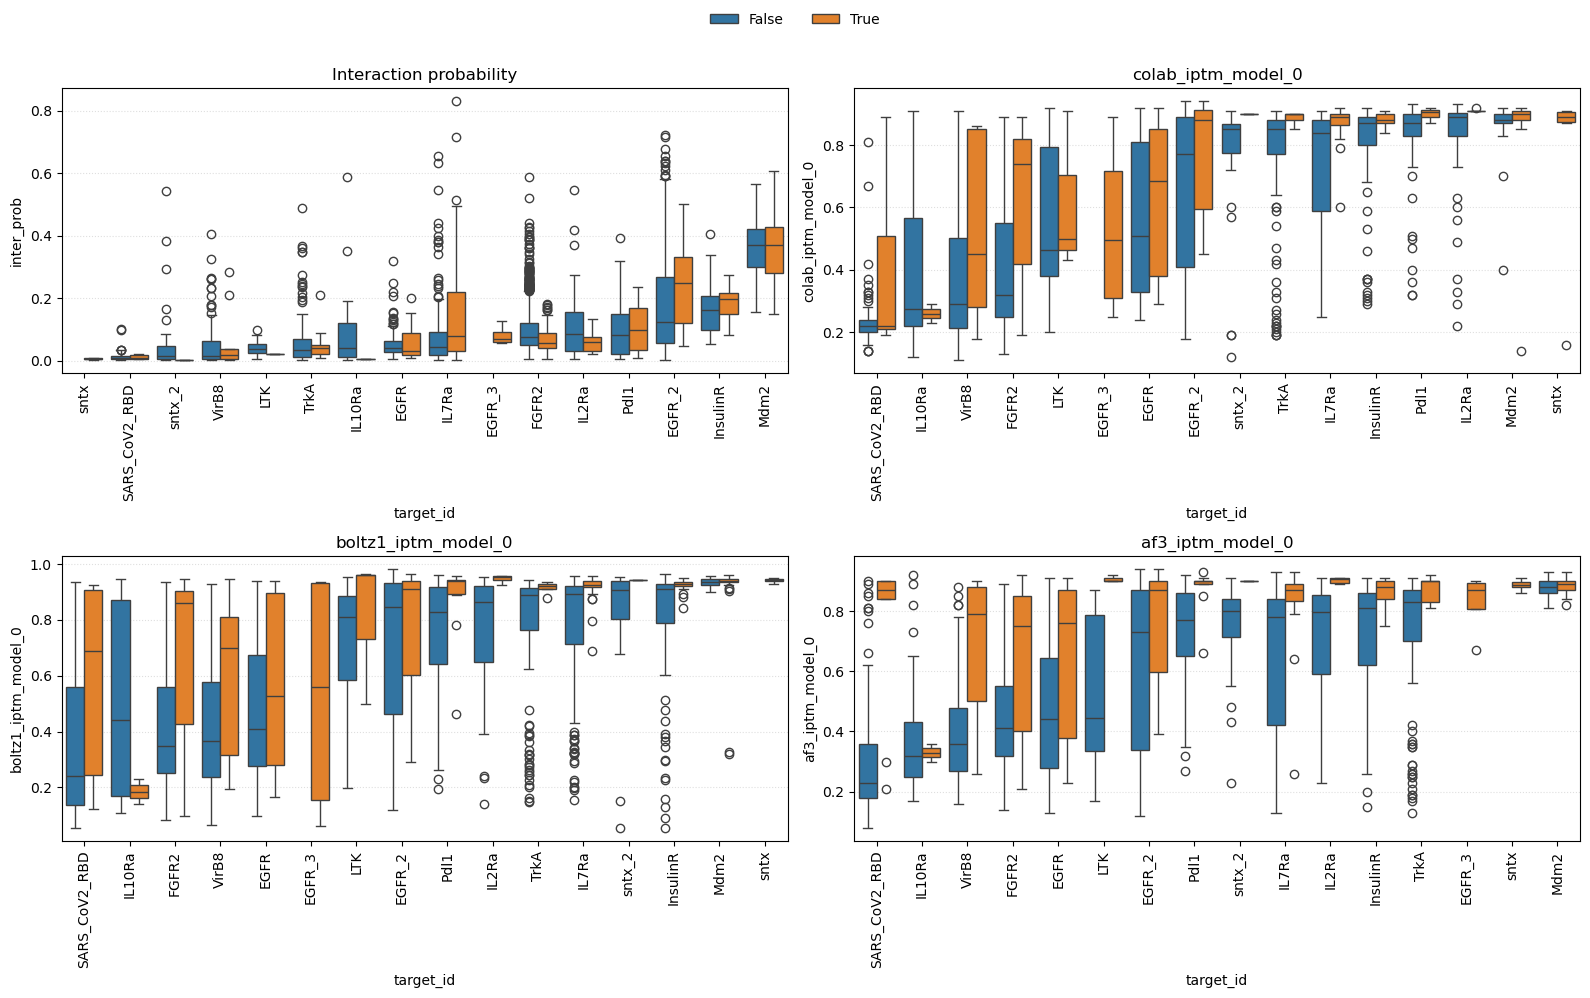

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
ax11, ax12 = axes[0]
ax21, ax22 = axes[1]

def plot_box(ax, ycol, title):
    # Optional: order targets by median value for nicer sorting
    order = (combined_df.groupby("target_id")[ycol].median().sort_values().index)

    sns.boxplot(data=combined_df, x="target_id", y=ycol, hue="binder_label", order=order, ax=ax)
    
    ax.set_title(title)
    ax.tick_params(axis="x", rotation=90)
    ax.grid(True, axis="y", linestyle=":", alpha=0.4)
    # Remove per-axes legend; we’ll add a single shared one
    leg = ax.get_legend()
    if leg is not None:
        leg.remove()

plot_box(ax11, "inter_prob",           "Interaction probability")
plot_box(ax12, "colab_iptm_model_0",   "colab_iptm_model_0")
plot_box(ax21, "boltz1_iptm_model_0",  "boltz1_iptm_model_0")
plot_box(ax22, "af3_iptm_model_0",     "af3_iptm_model_0")

# Shared legend from the last plotted Axes
handles, labels = ax22.get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=len(labels), frameon=False)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave space for legend at top
plt.show()

In [58]:
np.asarray(interaction_df["inter_prob"])

array([0.09129739, 0.06851482, 0.04366476, ..., 0.41702026, 0.02633999,
       0.00732969], dtype=float32)

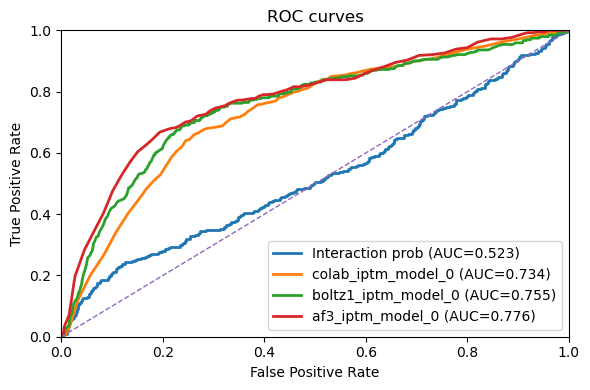

In [59]:
scores = {
    "Interaction prob": np.asarray(interaction_df["inter_prob"]),
    "colab_iptm_model_0": np.asarray(combined_df["colab_iptm_model_0"]),    # <— fill in
    "boltz1_iptm_model_0": np.asarray(combined_df["boltz1_iptm_model_0"]),  # <— fill in
    "af3_iptm_model_0": np.asarray(combined_df["af3_iptm_model_0"]),        # <— fill in
}

plt.figure(figsize=(6,4))
for model, values in scores.items():
    fpr, tpr, _ = sklearn.metrics.roc_curve(true_labels, values)
    auc = roc_auc_score(true_labels, values)
    plt.plot(fpr, tpr, linewidth=2, label=f"{model} (AUC={auc:.3f})")

plt.plot([0,1],[0,1],"--", linewidth=1)
plt.xlim(0,1); plt.ylim(0,1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curves")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

#### AUC-PR

In [60]:
combined_df

,seq_binder,seq_target,target_id,binder_id,binder_label,inter_prob,binder_label_pred,intr_scores,target_binder_ID,colab_iptm_model_0,boltz1_iptm_model_0,boltz1_complex_plddt_model_0,af3_iptm_model_0
0,LDFIVFAGPEKAIKFYKEMAKRNLEVKIWIDGDWAVVQVK,ANPYISVANIMLQNYVKQREKYNYDTLKEQFTFIKNASTSIVYMQF...,VirB8,VirB8_1,False,0.091297,False,-2.297896,VirB8_1,0.38,0.893,0.948,0.59
1,SEQDETMHRIVRSVIQHAYKHNDEMAEYFAQNAAEIYKEQNKSEEA...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_1,False,0.068515,False,-2.609730,FGFR2_1,0.24,0.260,0.756,0.37
2,DYKQLKKHATKLLELAKKDPSSKRDLLRTAASYANKVLFEDSDPRA...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_2,False,0.043665,False,-3.086567,FGFR2_2,0.25,0.457,0.764,0.39
3,DEKEELERRANRVAFLAIQIQNEEYHRILAELYVQFMKAAENNDTE...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_3,False,0.037765,False,-3.237874,FGFR2_3,0.88,0.177,0.810,0.51
4,PDNKEKLMSIAVQLILRINEAARSEEQWRYANRAAFAAVEASSGSD...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_4,False,0.068213,False,-2.614462,FGFR2_4,0.26,0.290,0.768,0.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3527,DLRKYAAELVDRLAEKYNLDSDQYNALVRLASELVWQGKSKEEIEK...,ELCDDDPPEIPHATFKAMAYKEGTMLNCECKRGFRRIKSGSLYMLC...,IL2Ra,IL2Ra_62,False,0.065263,False,-2.661835,IL2Ra_62,0.90,0.908,0.825,0.73
3528,SKEEIKKEAEELIEELKKKGYNLPLRILEFALKEIEETNSEKYYEQ...,ELCDDDPPEIPHATFKAMAYKEGTMLNCECKRGFRRIKSGSLYMLC...,IL2Ra,IL2Ra_63,False,0.022691,False,-3.762822,IL2Ra_63,0.87,0.928,0.825,0.81
3529,SPEYKKFLELIKEAEAARKAGDLDKAKELLEKALELAKKMKAKSLI...,ELCDDDPPEIPHATFKAMAYKEGTMLNCECKRGFRRIKSGSLYMLC...,IL2Ra,IL2Ra_64,False,0.417020,False,-0.335018,IL2Ra_64,0.87,0.917,0.813,0.76
3530,DPLLAYKLLKLSQKALEKAYAEDRERAEELLEEAEAALRSLGDEAG...,ELCDDDPPEIPHATFKAMAYKEGTMLNCECKRGFRRIKSGSLYMLC...,IL2Ra,IL2Ra_65,False,0.026340,False,-3.609974,IL2Ra_65,0.91,0.559,0.802,0.55


In [61]:
true_labels
pred_PPint = np.asarray(combined_df.inter_prob)
pred_colab = np.asarray(combined_df.colab_iptm_model_0)
pred_af3 = np.asarray(combined_df.af3_iptm_model_0)
pred_boltz = np.asarray(combined_df.boltz1_iptm_model_0)

AP_PPint = average_precision_score(true_labels, pred_PPint)
AP_colab = average_precision_score(true_labels, pred_colab)
AP_af3 = average_precision_score(true_labels, pred_af3)
AP_boltz = average_precision_score(true_labels, pred_boltz)

print(f"Average precission of PPint model:{AP_PPint:.4f}")
print(f"Average precission of colab model:{AP_colab:.4f}")
print(f"Average precission of AF3 model:{AP_af3:.4f}")
print(f"Average precission of Boltz model:{AP_boltz:.4f}")

Average precission of PPint model:0.1474
Average precission of colab model:0.2369
Average precission of AF3 model:0.3217
Average precission of Boltz model:0.2763


Average precision (AP):
  PPint: 0.1474
  Colab: 0.2369
  AF3: 0.3217
  Boltz: 0.2763


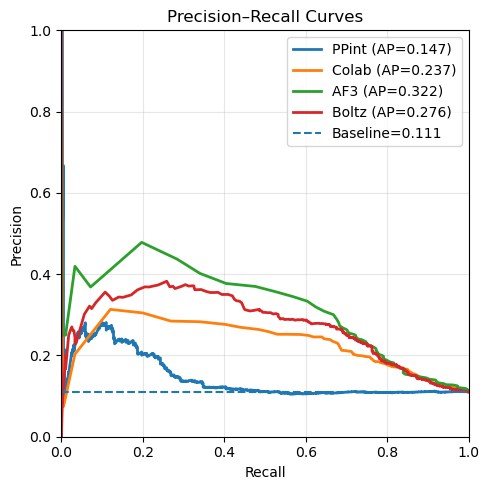

In [62]:
models = {
    "PPint": pred_PPint,
    "Colab": pred_colab,
    "AF3":   pred_af3,
    "Boltz": pred_boltz,
}

# Compute and print APs
print("Average precision (AP):")
ap_values = {}
for name, scores in models.items():
    ap = average_precision_score(true_labels, scores)
    ap_values[name] = ap
    print(f"  {name}: {ap:.4f}")

# Plot PR curves
plt.figure(figsize=(5,5))

for name, scores in models.items():
    precision, recall, _ = precision_recall_curve(true_labels, scores)
    ap = ap_values[name]
    plt.plot(recall, precision, label=f"{name} (AP={ap:.3f})", linewidth=2)

# Baseline = positive class prevalence
pos_rate = true_labels.mean()
plt.hlines(pos_rate, 0, 1, linestyles="dashed", label=f"Baseline={pos_rate:.3f}")

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()